In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [3]:
from src.utils.general import get_db_conn
from src.pipeline.text_preprocessing import run_preprocessing_steps

In [4]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)

### Testing the Doc2Vec functions

In [5]:
from src.bill_passage.doc2vec import prepare_documents, train_model, predict_vectors

ModuleNotFoundError: No module named 'src.bill_passage.doc2vec'

In [7]:
steps = ['remove_numbers', 'remove_punctuation', 'remove_stop_words']

In [6]:
q = """
    select doc_id, bill_id, doc from raw.bill_text_es limit 200;
"""
df = pd.read_sql(q, db_con)

In [10]:
df.doc[0]

'BILL NUMBER: SB 1136\tINTRODUCED\n\tBILL TEXT\nINTRODUCED BY   Senators Huff and Mitchell\n                        FEBRUARY 20, 2014\n   An act to amend Sections 1522 and 1522.08 of the Health and Safety\nCode, to amend Section 11105 of the Penal Code, and to amend Section\n16504.5 of the Welfare and Institutions Code, relating to foster\ncare.\n\tLEGISLATIVE COUNSEL\'S DIGEST\n   SB 1136, as introduced, Huff. Foster care providers: criminal\nrecords.\n    Existing law requires the State Department of Social Services to\nlicense and regulate community care facilities, including foster\nfamily homes, certified family homes of licensed foster family\nagencies, and group homes. Existing law requires that persons\nproviding care or services at these homes or facilities obtain either\na criminal record clearance or an exemption from disqualification\nfrom the department, as prescribed.\n   Existing law authorizes a child welfare agency to secure from an\nappropriate governmental criminal j

In [8]:
docs_all = df['doc'].tolist() 

In [9]:
train_docs = docs_all[:120]
test_docs = docs_all[120:]

In [10]:
train_corpus = prepare_documents(train_docs, steps, train=True)

In [9]:
test_corpus = prepare_documents(test_docs, steps, train=False)

NameError: name 'prepare_documents' is not defined

In [12]:
hp = {'vector_size': 60, 'min_count': 15, 'epochs': 20}

d2v = train_model(train_corpus, hp)

In [14]:
inferred_vecs = predict_vectors(test_corpus, d2v)

In [16]:
# inferred_vecs

### Fetch some bills

In [61]:
q = """
    select doc_id, bill_id, doc from raw.bill_text_es limit 100;
"""
df = pd.read_sql(q, db_con)

In [62]:
# df['doc'].tolist()

#### Preprocess

In [63]:
steps = ['remove_numbers', 'remove_punctuation', 'remove_stop_words']
preprocessed = run_preprocessing_steps(df['doc'].tolist(), steps)

In [21]:
preprocessed

['bill number sb introduced bill text introduced senators huff mitchell february act amend sections 152208 health safety code amend section penal code amend section 165045 welfare institutions code relating foster care legislative counsel digest sb introduced huff foster care providers criminal records existing law requires state department social services license regulate community care facilities including foster family homes certified family homes licensed foster family agencies group homes existing law requires persons providing care services homes facilities obtain either criminal record clearance exemption disqualification department prescribed existing law authorizes child welfare agency secure appropriate governmental criminal justice agency state summary criminal history information specified purposes including assessment appropriateness placing child subject jurisdiction juvenile court relative nonrelative extended family member bill would authorize state department social se

#### Tokenize

In [64]:
token_list = [x.split(' ') for x in preprocessed]

In [178]:
from gensim.summarization.textcleaner import tokenize_by_word

In [181]:
token_list[0]

['bill',
 'number',
 'sb',
 'introduced',
 'bill',
 'text',
 'introduced',
 'senators',
 'huff',
 'mitchell',
 'february',
 'act',
 'amend',
 'sections',
 '152208',
 'health',
 'safety',
 'code',
 'amend',
 'section',
 'penal',
 'code',
 'amend',
 'section',
 '165045',
 'welfare',
 'institutions',
 'code',
 'relating',
 'foster',
 'care',
 'legislative',
 'counsel',
 'digest',
 'sb',
 'introduced',
 'huff',
 'foster',
 'care',
 'providers',
 'criminal',
 'records',
 'existing',
 'law',
 'requires',
 'state',
 'department',
 'social',
 'services',
 'license',
 'regulate',
 'community',
 'care',
 'facilities',
 'including',
 'foster',
 'family',
 'homes',
 'certified',
 'family',
 'homes',
 'licensed',
 'foster',
 'family',
 'agencies',
 'group',
 'homes',
 'existing',
 'law',
 'requires',
 'persons',
 'providing',
 'care',
 'services',
 'homes',
 'facilities',
 'obtain',
 'either',
 'criminal',
 'record',
 'clearance',
 'exemption',
 'disqualification',
 'department',
 'prescribed',
 'e

In [183]:
bill_tokens = [list(tokenize_by_word(x)) for x in preprocessed]

### Doc2Vec

In [105]:
# preprocessed[0]

In [108]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#### Preparing data

In [115]:
def tag_training_corpus(train_corpus):
    """ Tag the train courps. The corpus needs to be preprocessed and tokenised"""
    for i, d in enumerate(train_corpus):
        yield TaggedDocument(d, [i])    

In [186]:
tagged_corpus = list(tag_training_corpus(bill_tokens))

#### Modeling

In [215]:
d2v = Doc2Vec(vector_size=60, min_count=15, epochs=20)

In [216]:
d2v.build_vocab(tagged_corpus)

In [217]:
d2v.train(tagged_corpus, total_examples=model.corpus_count, epochs=model.epochs)

#### Infering vectors of all train docs

In [218]:
ranks = list()
second_ranks = list()

vectors = list() 
for doc_id, tokens in enumerate(bill_tokens):
    inferred_vector = d2v.infer_vector(tokens)
    vectors.append(inferred_vector)
    
    sims = d2v.docvecs.most_similar([inferred_vector], topn=len(d2v.docvecs))
    rank = [doc_id for doc_id, sim in sims].index(doc_id)
    
    ranks.append(rank)
    second_ranks.append(sims[1])    

In [219]:
from collections import Counter

In [220]:
counter = Counter(ranks)

In [221]:
counter

Counter({0: 37, 1: 20, 2: 15, 3: 10, 4: 11, 6: 4, 5: 3})

In [222]:
d2v.docvecs[1]

array([ 1.9817135 ,  0.8464662 , -0.8299688 , -0.3985419 ,  1.5734247 ,
       -1.2096735 ,  0.5090546 ,  0.48248792,  0.83257115,  0.7759555 ,
       -1.1992221 , -0.13838534,  1.9626251 , -0.7063043 , -0.48947227,
       -3.0006306 ,  0.21167734,  2.7469583 , -1.727202  , -1.1113356 ,
       -0.13621046, -0.98824936, -0.45121425, -1.0718964 , -2.62196   ,
       -0.46590728, -1.5682099 , -0.1830762 ,  0.14907488,  0.09290268,
       -0.9317447 ,  2.2295823 , -3.2197313 , -0.29285765,  0.29432845,
       -0.2054536 , -1.2521999 , -2.5427067 , -0.21349859,  0.07579111,
       -3.5180745 ,  4.3921247 ,  1.8759927 , -0.8474055 , -2.8677413 ,
        0.5117047 ,  0.69188946, -0.28413963, -0.26635152,  0.18768667,
       -2.0708203 ,  0.03991514,  0.47179982, -0.98315734,  0.22667332,
       -1.4330345 ,  2.2516057 , -0.8523704 ,  1.5157261 ,  0.49765047],
      dtype=float32)

#### Model

In [90]:
model = Word2Vec(
    token_list,
    size=100,
    window=5,
    min_count=100,
    workers=2
)

In [91]:
words = list(model.wv.vocab)

In [92]:
# words[:10]

In [93]:
# model.wv['introduced']

In [94]:
X = model[words]

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


### PCA

In [95]:
pca = PCA(n_components=2)
results = pca.fit_transform(X)

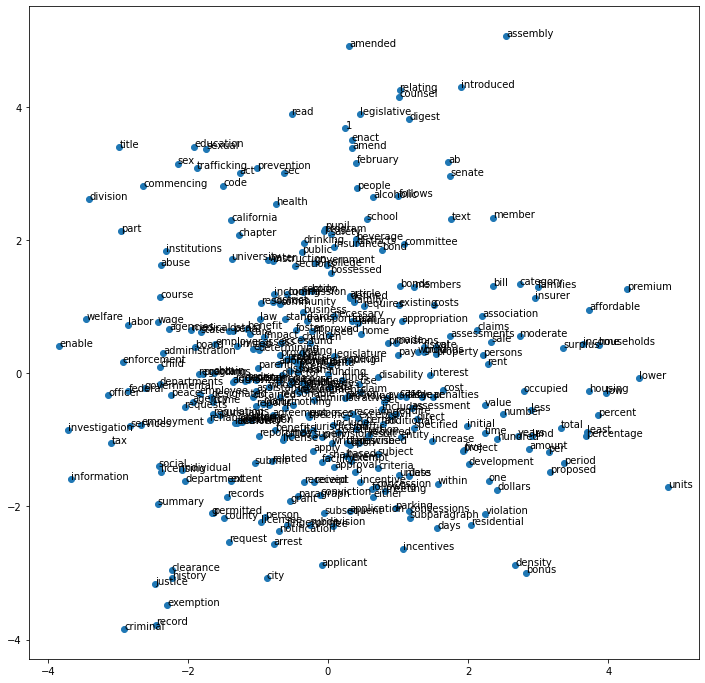

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.scatter(results[:, 0], results[:, 1])
for i, word in enumerate(words):
    ax.annotate(word, xy=(results[i,0], results[i, 1]))

In [101]:
model.wv.most_similar(positive = ['penalty'])

KeyError: "word 'penalty' not in vocabulary"

In [ ]:
model.wv.